# Аналитика в авиакомпании

## Постановка задачи

Компания «F9» — это российская авиакомпания, выполняющая внутренние пассажирские авиаперевозки. Сотни перелётов каждый день. Важно понять предпочтения пользователей, покупающих билеты на те или иные направления.

Необходимо изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

### Что уже сделано ранее

1. Был написан парсер для сбора данных о 10 крупнейших фестивалях 2018 года с сайта https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html
2. С помощью ряда SQL-запросов к базе были получены данные для дальнейшего анализа средствами Python.

Ниже скрипты, которыми получены исходные данные.

Таблица festivals

        import pandas as pd
        import requests 
        from bs4 import BeautifulSoup 


        URL='https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
        req = requests.get(URL) 
        soup = BeautifulSoup(req.text, 'lxml')

        table = soup.find('table',attrs={"id": "best_festivals"})

        heading_table = []
        for row in table.find_all('th'):
            heading_table.append(row.text) 

        content=[] 
        for row in table.find_all('tr'):
            if not row.find_all('th'): 
                content.append([element.text for element in row.find_all('td')])

        festivals = pd.DataFrame(content, columns=heading_table)
        print(festivals)

Таблица query_3

        select
            subquery.city as city,
            avg(subquery.total_flights) as average_flights
        from
            (
            select
                airports.city as city,
                EXTRACT("day" FROM flights.arrival_time) AS flight_date,
                count(flights.flight_id) as total_flights
            from
                flights 
                join airports on airports.airport_code = flights.arrival_airport
            where
                cast(flights.arrival_time as date) between '2018-08-01' and '2018-08-31'
            group by
                city,
                flight_date
            ) as subquery
        group by
            city

Таблица query_last

        select
            extract('week' from flights.arrival_time :: date) as week_number,
            count(ticket_flights.ticket_no) as ticket_amount,
            subq.festival_week as festival_week,
            subq.festival_name as festival_name
            
        from flights

        join ticket_flights on ticket_flights.flight_id = flights.flight_id

        join airports on airports.airport_code = flights.arrival_airport

        left join 
            (
            select
                festival_name,
                extract('week' from festival_date) as festival_week
            from festivals
            where 
                festival_date between '2018-07-23' and '2018-09-30' and
                festival_city = 'Москва'
            ) as subq on subq.festival_week = extract('week' from flights.arrival_time)
            
        where
            airports.city = 'Москва' and
            flights.arrival_time :: date between '2018-07-23' and '2018-09-30'
        group by
            week_number,
            festival_week,
            festival_name;

### Описание полученных данных

/datasets/query_1.csv — результат первого запроса. В нём содержится информация о количестве рейсов с вылетом в сентябре 2018 года на каждой модели самолёта:
* model — модели самолета
* flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года

/datasets/query_3.csv — результат третьего запроса. В нём содержится информация о среднем количестве прибывающих рейсов в день для каждого города за август 2018 года:
* city — города
* average_flights — среднее количество рейсов, прибывающих в город city за день в сентябре 2018 года

/datasets/query_last.csv — результат последнего запроса. В нём следующая информация:
* week_number — номер недели;
* ticket_amount — количество проданных билетов за неделю;
* festival_week — есть ли на этой неделе фестиваль;
* festival_name — название фестиваля.

### Что необходимо сделать

Для первых двух наборов данных нужно:
* выбрать топ-10 городов по количеству рейсов;
* построить графики: модели самолетов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;

На основе последнего файла необходимо проверить гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

## Исследовательский анализ средствами Python

### Количество рейсов за месяц с разбивкой по модели самолета

Импортируем библиотку pandas для работы с выгруженными данными.

In [1]:
import pandas as pd

Первая выгрузка - информация о количестве рейсов с вылетом в сентябре 2018 года на каждой модели самолёта. Откроем файл и прочитаем его в датафрейм. Название датафрейму дадим по номеру запроса. Изучим общую информацию о файле.

In [2]:
df_1 = pd.read_csv('datasets/query_1.csv')
df_1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


Все данные на месте и имеют корректный тип: название модели - строка, количество полетов - целое число.

Построим график зависимости количества рейсов от модели самолета.

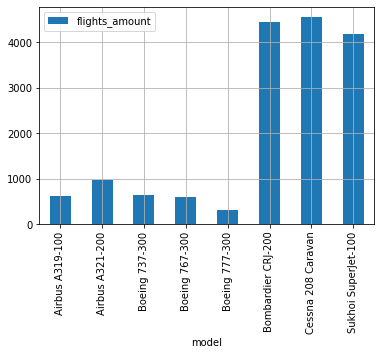

In [4]:
%matplotlib inline
df_1.plot(kind='bar', y='flights_amount', x='model', grid=True, legend=True)

Интересно, что в компании F9 на небольшие самолеты приходится большая часть рейсов. Можем предположить, что для внутренних перелетов, на которых специализируется F9, крупные самолеты менее актуальны, чем для международных.



### Среднее количество рейсов в день с разбивкой по городам

В следующей выгрузке посчитано среднее количество прибывающих рейсов в день для каждого города за сентябрь 2018 года. Откроем файл с результатами запроса и прочитаем его в датафрейм. Название датафрейму также присвоим по номеру запроса. Изучим общую информацию о файле.

In [5]:
df_3 = pd.read_csv('datasets/query_3.csv')
df_3

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


In [6]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


Данные выглядят корректно. Пропущенных значений нет; название города имеет строковый тип данных, а среднее количество рейсов в день - вещественный.

Оценим, как распределено среднее количество рейсов в день. Зададим для графика 130 корзин - по наибольшему значению для Москвы, чтобы каждый столбик гистограммы примерно соотвествовал количеству рейсов.

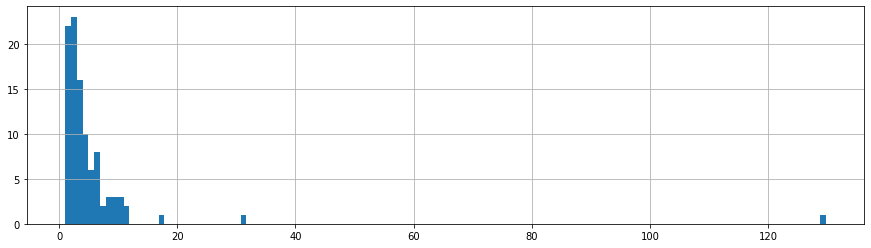

In [7]:
df_3['average_flights'].hist(bins=130, figsize=(15,4))

Для большинства городов среднее количество рейсов в день не превышает 6. 


Посмотрим на среднее количество рейсов в день для каждого города.

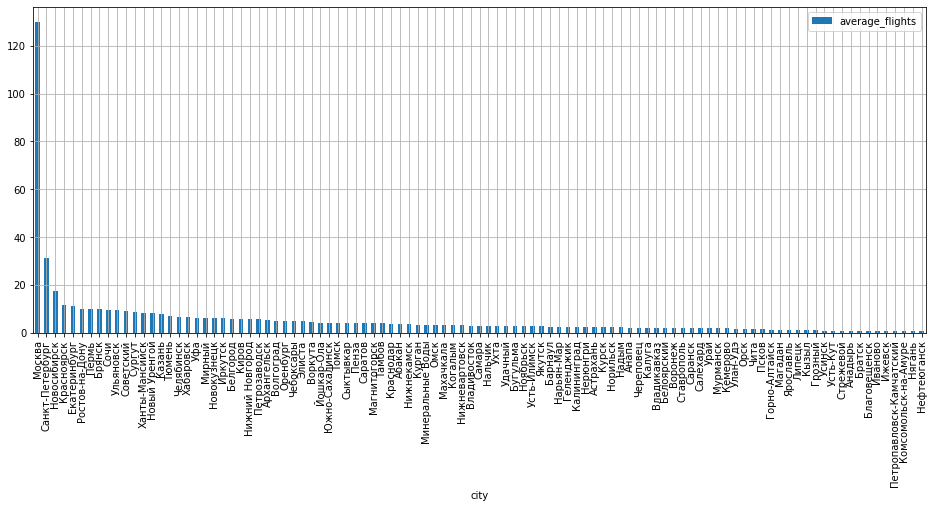

In [8]:
(df_3.sort_values(by='average_flights', ascending=False)
 .plot(kind='bar', y='average_flights', x='city', grid=True, legend=True, figsize=(16,6)))

График получился не очень читаемым, но видим примерно то же, что и на гистограмме: для большинства городов характерно малое колиство рейсов в день; есть отдельные города, где самолеты авиакомпании F9 летают чаще.



Выберем топ-10 городов по количеству рейсов в день.

In [9]:
top_10_cities = df_3.sort_values(by='average_flights', ascending=False).head(10)
top_10_cities

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


Посмотрим, сколько рейсов в день приходится в среднем на города из топа.

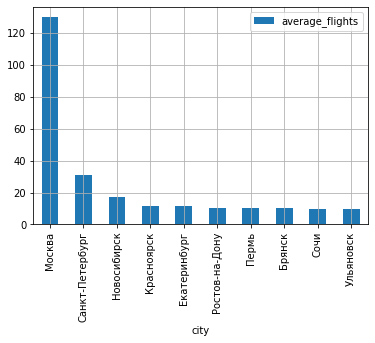

In [10]:
top_10_cities.plot(kind='bar', y='average_flights', x='city', grid=True, legend=True)

Москва - абсолютный лидер по количеству рейсов в день. Санкт-Петербург и Новосибирск можем считать крупными городами для авиакомпании F9. Остальные города топа - около 10 рейсов в день. Это значение, однако, выше среднего по всем городам.



### Вывод

Был проведен исследовательский анализ данных методами Python. Было изучено:
* как распределено количество полетов в месяц в зависимости от модели самолета. В авиакомпании F9 большинство рейсов приходится на небольшие и средние самолеты Bombardier CRJ-200, Cessna 208 Caravan, Sukhoi SuperJet-100;
* как распределено среднее количество рейсов в день по городам. Для большинства среднее количество рейсов в день не превышает 6;
* как распределено среднее количество рейсов в день для топ-10 городов. Москва - абсолютный лидер по количеству рейсов в день. Санкт-Петербург и Новосибирск можем считать крупными городами для данной авиакомпании. Остальные города топа - в районе 10 рейсов в день.

## Проверка гипотезы средствами Python

Требуется проверить утверждение: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время». Примем его за нулевую гипотезу H0, так как данное утверждение уже сформулировано с позиции равенства. Тогда альтернативная гипотеза H1: средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время. Так мы сможем использовать t-тест для проверки гипотезы о равенстве средних двух генеральных совокупностей.

В файле query_last.csv представлена информация о количестве билетов, купленных на рейсы в Москву с разбивкой по неделям; там же информация о том, является ли неделя фестивальной.

Прочитаем файл в датафрейм, присвоив ему имя запроса.

In [11]:
df_last = pd.read_csv('datasets/query_last.csv')
df_last

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


In [12]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes


Данные соответствуют ожидаемым. Пропуски в столбцах festival_week и festival_name означают, что в данную неделю фестивалей в Москве не было. Можем использовать эти пропущенные значения, чтобы отделить фестивальные недели от обычных.

Выделим недели, в которые проходили фестивали в Москве. От всего датафрейма нам нужно только количество проданных билетов на рейсы.

In [13]:
festivals = df_last.dropna(subset=['festival_week', 'festival_name'])['ticket_amount']
festivals

0    43568
1    51034
6    51386
Name: ticket_amount, dtype: int64

Выделим недели, в которые фестивалей в Москве не было.

In [14]:
no_festivals = df_last[df_last['festival_week'] != df_last['festival_week']]['ticket_amount']
no_festivals

2    51675
3    51378
4    51492
5    51360
7    51670
8    51518
9    51623
Name: ticket_amount, dtype: int64

Мы получили две совокупности, для которых можно сравнивать их средние. Проведем статистический тест.

Воспользуемся методом ttest_ind библиотеки scipy. Пороговое значение alpha зададим в 5%.

In [15]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(festivals, no_festivals)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09688869045922928
Не получилось отвергнуть нулевую гипотезу


Среднее количество проданных билетов в фестивальные недели и в обычное время достаточно близко, чтобы мы не могли отвергнуть гипотезу об их равенстве. Видимо, в Москву летают настолько часто, что наличие фестивалей не повлияло на спрос.



### Вывод

Был проведен статистиеский тест для проверки гипотезы о равенстве средних для двух генеральных совокупностей. Пороговое значение alpha было выбрано в 5%.

Не удалось отвергнуть гипотезу о том, что средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.

## Итоги

На основе подготовленных ранее данных был проведен исследовательский анализ данных  и проверена гипотеза средствами Python.

Для авиакомпании F9 было установлено следующее:
* большинство рейсов приходится на небольшие и средние самолеты Bombardier CRJ-200, Cessna 208 Caravan, Sukhoi SuperJet-100. На самолеты Airbus и Boeing приходится меньшее число рейсов;
* для большинства городов среднее количество рейсов в день не превышает 6;
* среди топ-10 городов Москва - абсолютный лидер по количеству рейсов в день (129.8). Санкт-Петербург (31,2) и Новосибирск (17,3) можем считать крупными городами для данной авиакомпании. Остальные города топа - в районе 10 рейсов в день.
* средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время - с вероятностью ошибки 5% мы не смогли отвергнуть данную гипотезу.